In [1]:
%matplotlib inline
import numpy as np
import sklearn as skl
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
train_path = 'mnist'
test_path = 'mnist.t'
data_dim = 784

def reader(path):
    data_img = []
    data_label = []
    with open(str(path),'r') as FP:
        for line in FP:
            segment = line.split(' ')
            label = segment[0]
            img = np.zeros(data_dim, dtype=np.float32)
            for v in segment[1:]:
                index, value = v.split(':')
                img[int(index)] = float(value) / 255.
            data_img.append(img)
            data_label.append(int(label))
    return np.array(data_img), np.array(data_label)



In [3]:
training_img, training_label = reader(train_path)
testing_img, testing_label = reader(test_path)
print len(training_img)
print len(testing_img)

60000
10000


In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
reduced_train_img = pca.fit_transform(training_img)
print 'Information left: ', np.sum(pca.explained_variance_ratio_)

Information left:  0.643562


Search meta-parameters
Reference: https://github.com/thuijskens/bayesian-optimization/blob/master/ipython-notebooks/svm-optimization.ipynb

In [5]:
def sample_loss(params): ## log scale
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1]),
                           reduced_train_img, training_label, cv=3, n_jobs=3).mean()


In [6]:
lambdas = np.linspace(1, -4, 5) ## from 0.0001 ~ 10 in 5 steps (log scale)
gammas = np.linspace(1, -4, 5)
# sample_loss([0,0])
# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

real_loss = [sample_loss(params) for params in param_grid]

/Users/kuang-yujeng/Library/Python/2.7/lib/python/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/kuang-yujeng/Library/Python/2.7/lib/python/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


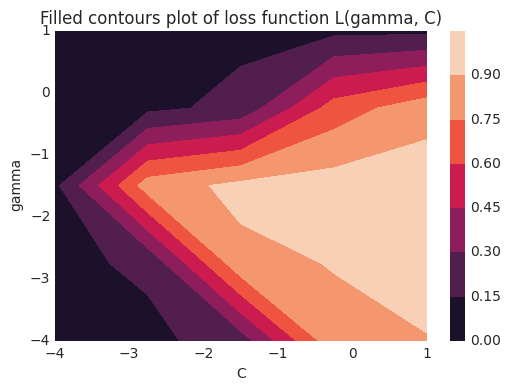

1.0 -1.5


In [7]:
C, G = np.meshgrid(lambdas, gammas)
ax = plt.subplot()
cp = ax.contourf(C, G, np.array(real_loss).reshape(C.shape))
cbar = plt.colorbar(cp, ticks=np.arange(0., 1.0, 0.15))
ax.set_title('Filled contours plot of loss function L(gamma, C)')
ax.set_xlabel('C')
ax.set_ylabel('gamma')
plt.show()

# The maximum is at:
C, gamma = param_grid[np.array(real_loss).argmax(), :]
print C, gamma

In [8]:
clf = SVC(C=10**C, gamma=10**gamma, verbose=False)

10-fold Cross-validation

In [9]:
scores = cross_val_score(clf, reduced_train_img, training_label, cv=10)
print ''
print '-'*8+' 10-fold cross-validation '+'-'*8
for s in scores:
    print s
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


-------- 10-fold cross-validation --------
0.983516483516
0.980176578377
0.978003666056
0.981666666667
0.9755
0.978996499417
0.976829471579
0.978996499417
0.976821744205
0.984823215477
Accuracy: 0.98 (+/- 0.01)


Okay. Now testing on testing set.

In [10]:
reduced_testing_img = pca.transform(testing_img)
%time clf.fit(reduced_train_img, training_label)
predicted = clf.predict(reduced_testing_img)
confusion_metrix = skl.metrics.confusion_matrix(testing_label, predicted)
print confusion_metrix
inclass_precision = skl.metrics.classification_report(testing_label, predicted)
print inclass_precision

CPU times: user 21.7 s, sys: 354 ms, total: 22 s
Wall time: 22.8 s
[[ 973    0    1    1    0    2    1    1    1    0]
 [   0 1132    1    1    0    0    0    0    1    0]
 [   3    0 1012    4    1    1    0    7    4    0]
 [   0    1    2  994    0    4    0    4    4    1]
 [   0    0    1    0  965    0    4    0    1   11]
 [   2    0    0    8    1  870    3    1    5    2]
 [   5    4    1    0    4    4  938    1    1    0]
 [   0    5   11    2    2    0    0  997    0   11]
 [   2    0    3    4    3    5    2    2  951    2]
 [   2    4    0    5   11    5    0    8    1  973]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       980
          1       0.99      1.00      0.99      1135
          2       0.98      0.98      0.98      1032
          3       0.98      0.98      0.98      1010
          4       0.98      0.98      0.98       982
          5       0.98      0.98      0.98       892
          6       0.99      0.

In [11]:
mean_score_on_testing_set = clf.score(reduced_testing_img, testing_label)
print 'score on testing set:', mean_score_on_testing_set

score on testing set: 0.9805


In [12]:
def plot_embedding(x_emb,y,n,title=''):
    cmap = plt.cm.gist_ncar_r
    ax = plt.subplot()
    for l in xrange(n):
        points = x_emb[y==l,:]
        ax.scatter(points[:,0], points[:,1], label=l, c=cmap(float(l)/float(n)))
    ax.legend(loc='lower right', frameon=True, prop={'size': 10})
    ax.set_title(title)
    plt.show()

In [13]:
from sklearn.manifold import TSNE as tSNE

tsne = tSNE(n_components=2)
emb_testing_img = tsne.fit_transform(testing_img)

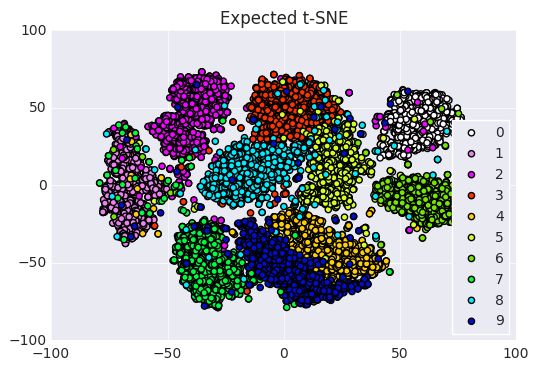

In [14]:
plot_embedding(emb_testing_img, testing_label, 10, 'Expected t-SNE')

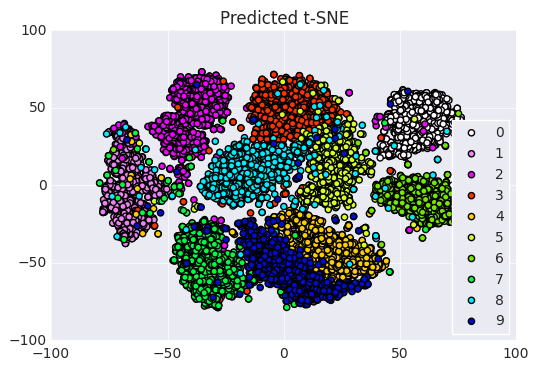

In [15]:
plot_embedding(emb_testing_img, predicted, 10, 'Predicted t-SNE')